<a href="https://colab.research.google.com/github/kwanhong66/KaggleShoveling/blob/master/EDA_%2B_Baseline_Model__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle kernal transcription study #6-1
### EDA + Baseline Model

- Kernal 주소
  * https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse
- Competition 주소
  * https://www.kaggle.com/c/nyc-taxi-trip-duration

## Dataset with Kaggle API

In [0]:
!pip3 install -q kaggle

In [2]:
!wget 'https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json'

--2020-03-09 05:37:02--  https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      63  --.-KB/s    in 0s      

2020-03-09 05:37:03 (14.2 MB/s) - ‘kaggle.json’ saved [63/63]



In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions list

ref                                                                deadline             category             reward  teamCount  userHasEntered  
-----------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                                                   2030-01-01 00:00:00  Getting Started   Knowledge       2291           False  
titanic                                                            2030-01-01 00:00:00  Getting Started   Knowledge      16455            True  
house-prices-advanced-regression-techniques                        2030-01-01 00:00:00  Getting Started   Knowledge       4610            True  
connectx                                                           2030-01-01 00:00:00  Getting Started   Knowledge        376           False  
competitive-data-science-predict-future-sales                      2020-12-31 23:59:00  Playground            Kudos       5909    

In [6]:
!kaggle competitions download -c nyc-taxi-trip-duration

 88% 18.0M/20.3M [00:00<00:00, 28.7MB/s]
100% 20.3M/20.3M [00:00<00:00, 32.0MB/s]
 94% 59.0M/62.9M [00:01<00:00, 38.2MB/s]
100% 62.9M/62.9M [00:01<00:00, 48.2MB/s]
  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 162MB/s]


In [0]:
!mkdir input

In [8]:
!unzip '*.zip' -d ./input/

Archive:  train.zip
  inflating: ./input/train.csv       

Archive:  test.zip
  inflating: ./input/test.csv        

Archive:  sample_submission.zip
  inflating: ./input/sample_submission.csv  

3 archives were successfully processed.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [10]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
test.shape

(625134, 9)

### Convert to appropriate datatype

convert pickup datetime and dropoff datetime into date-time object

In [11]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Are there any missing values in the data?

In [12]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

There are no missing values

### What is the time period of the dataset?

In [13]:
print("Min pickup time", min(train['pickup_datetime']))
print("Max pickup time", max(train['pickup_datetime']))

Min pickup time 2016-01-01 00:00:17
Max pickup time 2016-06-30 23:59:39


The data has 6 months of taxi trip data, from Jan to Jun 2016

### create new day, month, hour info from Pickup time

In [0]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x: x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x: x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

### Round lat lng to 3 decimal places

In [0]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x: round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x: round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x: round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x: round(x, 3))

In [16]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on Latitude and Longitude get the distance of the trip in km

This uses Haversine Distance
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
- https://en.wikipedia.org/wiki/Haversine_formula
- https://kayuse88.github.io/haversine/

In [0]:
def calculateDistance(row):
  R = 6373.0 # approximate radius of earth in km
  pickup_lat = radians(row['pickup_latitude'])
  pickup_lon = radians(row['pickup_longitude'])
  dropoff_lat = radians(row['dropoff_latitude'])
  dropoff_lon = radians(row['dropoff_longitude'])
  dlon = dropoff_lon - pickup_lon
  dlat = dropoff_lat - pickup_lat
  a = sin(dlat / 2) ** 2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2) ** 2
  c = 2 * atan2(sqrt(a), sqrt(1-a))
  distance = R * c
  return distance

In [18]:
train['trip_distance'] = train.apply(lambda row: calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [19]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### Exploratory Analysis

Text(0.5, 0, 'Trip Duration (in hour)')

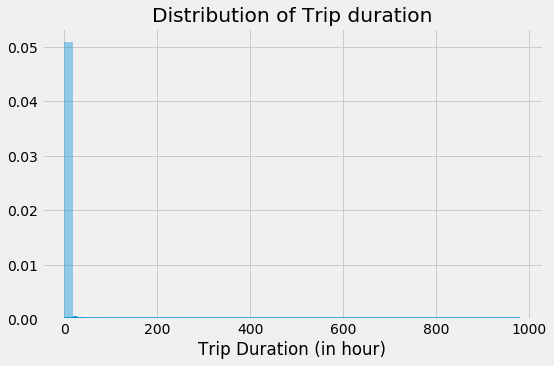

In [20]:
plt.figure(figsize=(8, 5))
sns.distplot(train['trip_duration_in_hour']).set_title('Distribution of Trip duration')
plt.xlabel('Trip Duration (in hour)')

There are trip duration greater than 24 hours. We will have to investigate this?

In [21]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,2016-01-05,5,0,Tuesday,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2016-02-13,13,22,Saturday,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2016-01-05,5,6,Tuesday,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2016-02-13,13,22,Saturday,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


There are 4 records which have very high trip duration, but the distance travelled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let us take log transformation.

We will not remove these from the analysis, because they might be a part of test data as well

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

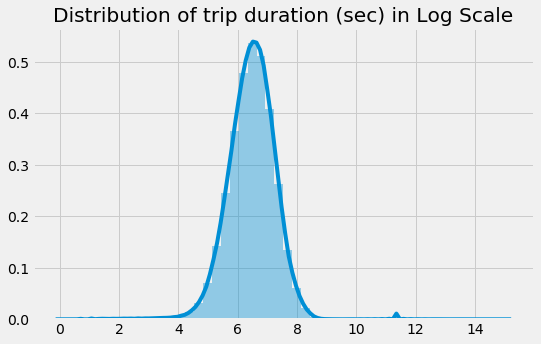

In [22]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec (exp(8)) . This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are within New York

### Heatmap of common locations from where pickup and dropoff occurs

In [0]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id': 'Num_Trips'})

In [24]:
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
print(pickup.shape)
### For each pickup point add a circlemaker
'''
for index, row in pickup.iterrows():

  folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                      radius=3,                     
                      fill_color="#3db7e4", 
                      fill_opacity=0.9
                     ).add_to(pickup_map)
  count = count + 1
'''
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values,
                           pickup.Num_Trips.values)),
                  min_opacity=0.2,
                  radius=5,
                  blur=15,
                  max_zoom=1)
pickup_map.add_child(hm_wide)

pickup_map

(13024, 3)


(-74.03, -73.75)

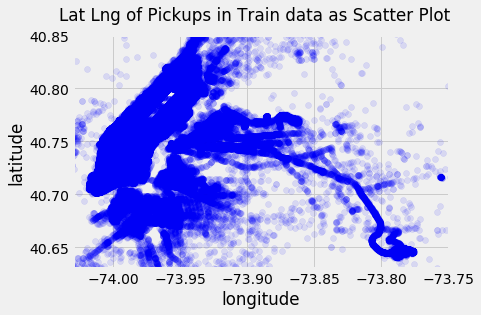

In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           color='blue', label='train', alpha=0.1)
fig.suptitle('Lat Lng of Pickups in Train data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

**This graph clearly shows heavy density of pickups near JFK**

In [0]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id': 'Num_Trips'})

In [27]:
drop_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in drop.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
    count=count + 1

'''
hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, 
                           drop.Num_Trips.values)),
                  min_opacity=0.2,
                  radius=5, blur=15,
                  max_zoom=1
                  )
drop_map.add_child(hm_wide)
drop_map

### heatmap of trip duration, when pickup originates from a point

In [0]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'Avg_Trip_duration'})

In [29]:
pickup_map = folium.Map(location=[40.730610,-73.935242], zoom_start=10)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values,
                           pickup.Avg_Trip_duration.values)),
                  min_opacity=0.2,
                  radius=7, blur=15,
                  max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

The average trip duration, when trip originates from JFK is higher. If we zoom in, we can see that after the Manhattan, The pickups from JFK tend to have higher trip duration

### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

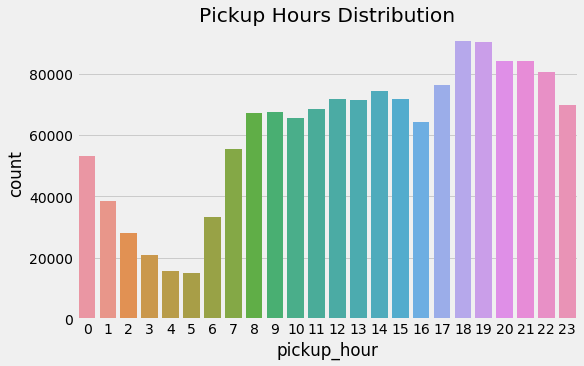

In [30]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

The pickups are much lower in the early mornings. Most pickips are around highest between 6 to 8 pm

Text(0.5, 1.0, 'Dropoff Hours Distribution')

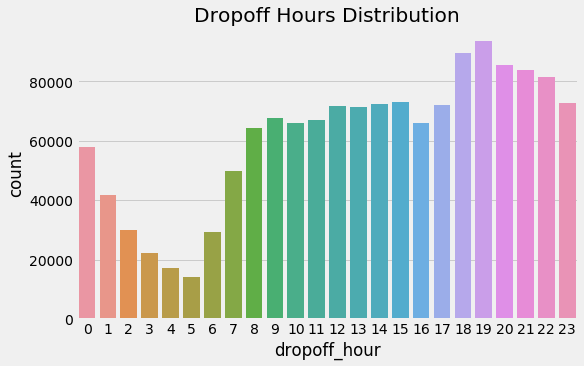

In [31]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title('Dropoff Hours Distribution')

Distribution of dropoff hour very similar to pickup hour

### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over time')

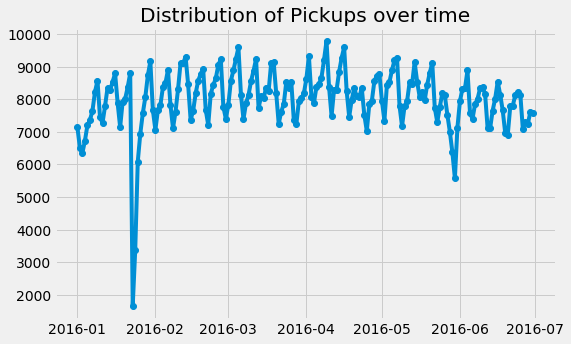

In [32]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title('Distribution of Pickups over time')

There is a drop seen in the number of pick ups in end the January 2016

### What is the distribution of Trip distance

Text(0.5, 0, 'Trip Distance (log)')

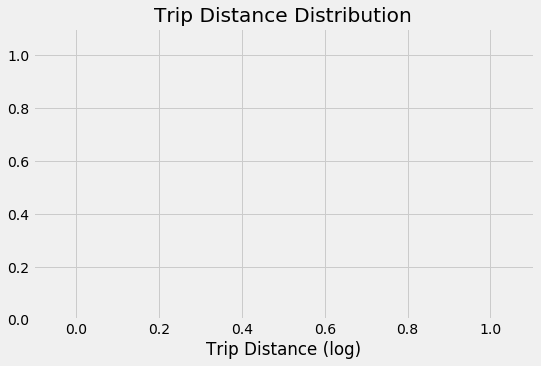

In [33]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

### Trip Duration vs Trip Distance

Text(0, 0.5, 'Trip Duration (log scale)')

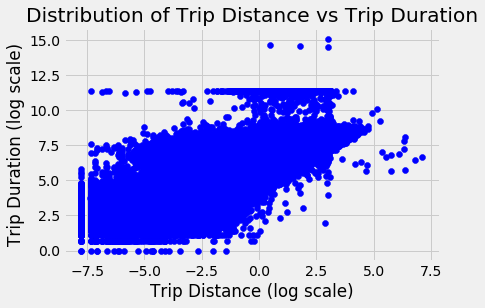

In [34]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color='blue', label='train')
plt.title('Distribution of Trip Distance vs Trip Duration')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Trip Duration (log scale)')

### Is the Trip duration higher at different hours?

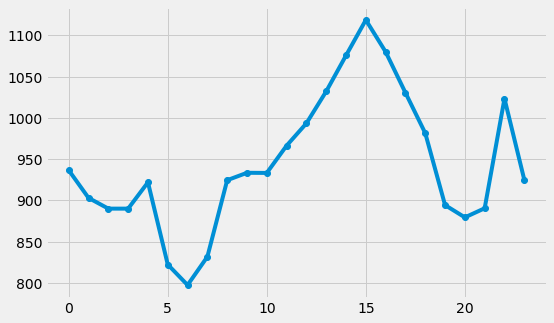

In [35]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')

Trip duration increases between 10 to 15 hours.

### Distribution of Pickups across Days

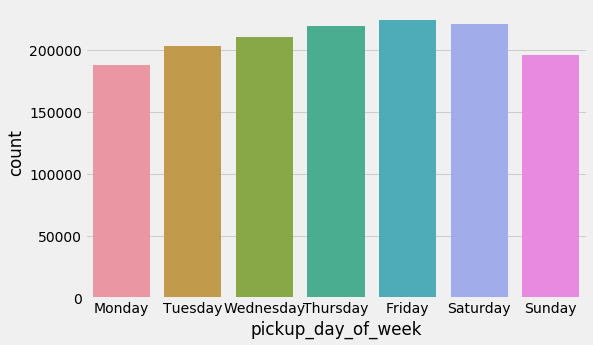

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'], order=['Monday', 'Tuesday', 'Wednesday',
                                                  'Thursday', 'Friday', 'Saturday', 'Sunday'])

The number of pickups are very low on Monday.From Tuesday to Friday the number of pickups keep increasing

### Avg Trip Duration over Days of week

In [0]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Durations Pickup Days of Week')

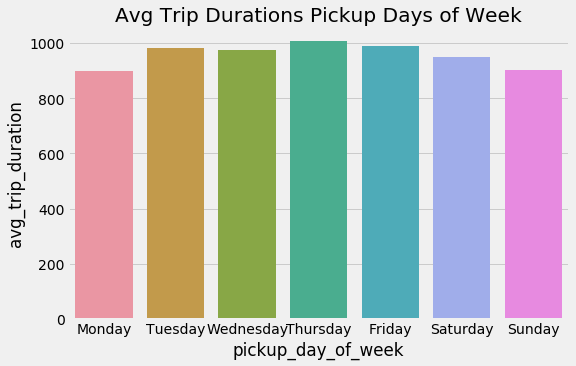

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title('Avg Trip Durations Pickup Days of Week')

The highest average speed is on Thursday

### Create a caluclated field Bearing
Bearing measures the direction of travel The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ is the longitude

In [0]:
def calculateBearing(lat1, lng1, lat2, lng2):
  R = 6371
  lng_delta_rad = np.radians(lng2 - lng1)
  lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
  y = np.sin(lng_delta_rad) * np.cos(lat2)
  x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
  return np.degrees(np.arctan2(y, x))

In [0]:
train['bearing'] = train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],
                                                           row['pickup_longitude_round3'],
                                                           row['dropoff_latitude_round3'],
                                                           row['dropoff_longitude_round3']), axis=1)

### Distribution of Bearing

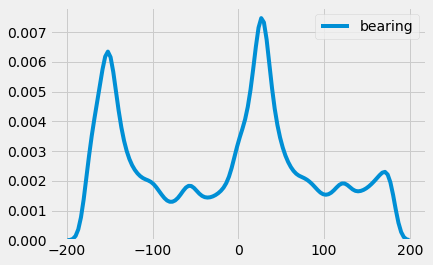

In [41]:
sns.kdeplot(train['bearing'])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

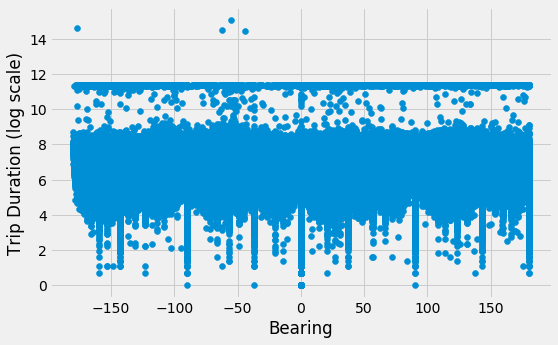

In [42]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel('Bearing')
plt.ylabel('Trip Duration (log scale)')

The outliers in trip duration are all around bearing -50 degrees

### Distribution of Store and FWD Flag

In [43]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

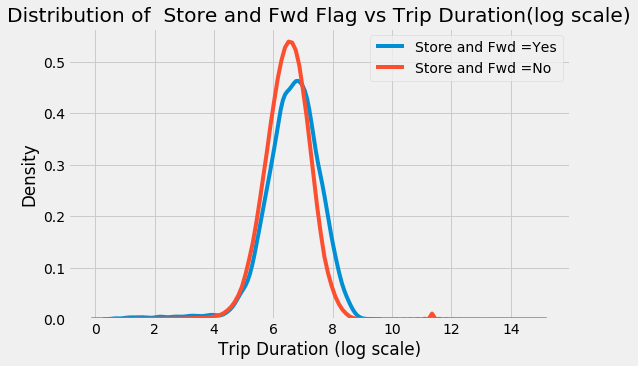

In [44]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration'].values),
            label='Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration'].values),
            label='Store and Fwd =No')
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

### Group Locations into cluster
This will help creating neighbourhoods. And pickups from certain neightbourhoods may have a longer trip duration

(-74.03, -73.75)

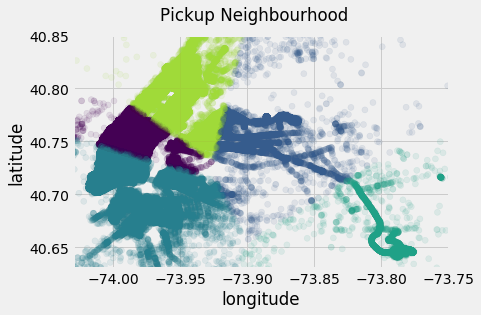

In [45]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighborhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighborhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           c=train['pickup_neighborhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### Number of pickups in each neighbourhood

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighborhoods')

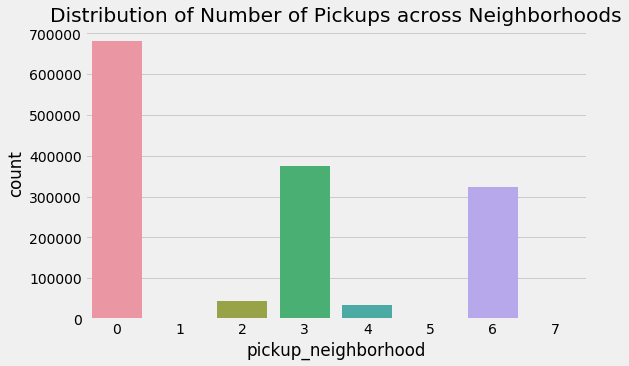

In [48]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighborhood']).set_title('Distribution of Number of Pickups across Neighborhoods')

Text(0.5, 1.0, 'Avg Trip Duration vs Neighborhood')

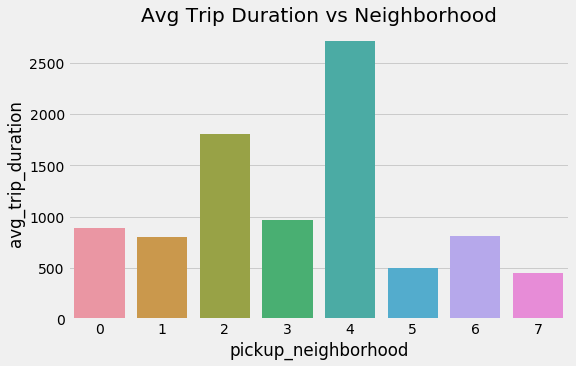

In [49]:
avg_duration_neighborhood = train.groupby(['pickup_neighborhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration': 'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighborhood', y='avg_trip_duration', data=avg_duration_neighborhood).set_title('Avg Trip Duration vs Neighborhood')

### Distribution of Average Speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

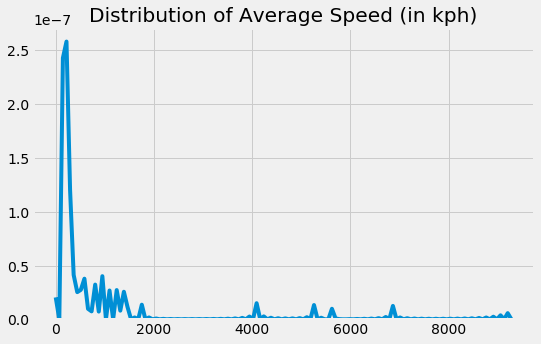

In [50]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title('Distribution of Average Speed (in kph)')

In [51]:
print('Average speed is', np.mean(train['avg_speed_kph']), 'kph')

Average speed is 14.427736738458588 kph


### Average Speed across days of week - this is indication of traffic speed.

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

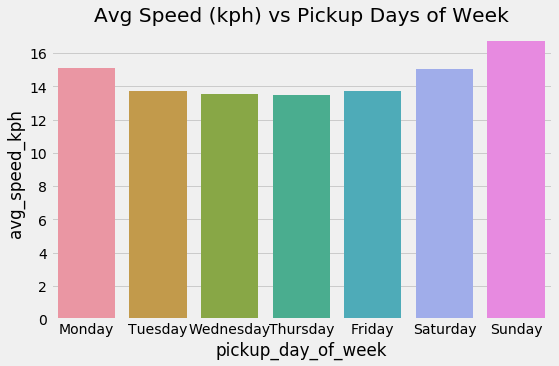

In [52]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).set_title('Avg Speed (kph) vs Pickup Days of Week')

The average speed is higher on sunday and monday.

### Feature Engineering on Test Data

In [0]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3'] = test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3'] = test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3'] = test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3'] = test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance'] = test.apply(lambda row: calculateDistance(row), axis=1)
test['bearing'] = test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],
                                                         row['pickup_longitude_round3'],
                                                         row['dropoff_latitude_round3'],
                                                         row['dropoff_longitude_round3']), axis=1)
test.loc[:, 'pickup_neighborhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighborhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### Building Models

From the training data we need to drop "dropoff datetime features". We also only keep lat lng rounded to 3 decimal places

In [0]:
drop_cols = ['avg_speed_kph', 'trip_duration_in_hour', 'dropoff_date', 'dropoff_day',
             'dropoff_hour', 'dropoff_day_of_week', 'dropoff_datetime', 'pickup_latitude',
             'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
training = train.drop(drop_cols, axis=1)             
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

We have to predict trip_duration. We will convert this to log scale and predict

In [0]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'], axis=1, inplace=True)

In [57]:
print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


Let us also encode day of week as numbers

In [0]:
def encodeDays(day_of_week):
  day_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
              'Friday': 5, 'Saturday': 6}
  return day_dict[day_of_week]

In [0]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x: encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x: encodeDays(x))

In [0]:
training.to_csv('input_training.csv', index=False)
testing.to_csv('input_testing.csv', index=False)
del training
del testing
del train
del test

In [0]:
def LabelEncoding(train_df, test_df, max_levels=2):
  for col in train_df:
    if train_df[col].dtype == 'object':
      if len(list(train_df[col].unique())) <= max_levels:
        le = preprocessing.LabelEncoder()
        le.fit(train_df[col])
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
  return (train_df, test_df)

In [0]:
def readInputAndEncode(input_path, train_file, test_file, target_column):
  training = pd.read_csv(input_path + train_file)
  testing = pd.read_csv(input_path + test_file)

  training, testing = LabelEncoding(training, testing)
  
  print('Training Data Shape after Encoding ', training.shape)
  print('Testing Data Shape after Encoding ', testing.shape)
  # Check if all train columns are there in test data. If not add the column to test data and replace it with zero
  train_cols = training.columns.tolist()
  test_cols = testing.columns.tolist()
  col_in_train_not_test = set(train_cols) - set(test_cols)
  for col in col_in_train_not_test:
    if col != target_column:
      testing[col] = 0
  col_in_test_not_train = set(test_cols) - set(train_cols)
  for col in col_in_test_not_train:
    training[col] = 0
  print('Training Data Shape after Processing', training.shape)
  print('Testing Data Shape after Processing', testing.shape)
  return [training, testing]

In [63]:
train, test = readInputAndEncode('', 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

Training Data Shape after Encoding  (1458644, 18)
Testing Data Shape after Encoding  (625134, 17)
Training Data Shape after Processing (1458644, 18)
Testing Data Shape after Processing (625134, 17)


In [0]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True):
  labels = np.array(train[target])
  training = train.drop(target, axis=1)
  training = np.array(training)
  testing = np.array(test)
  if imputation == True:
    imputer = SimpleImputer(strategy=imputing_strategy, missing_values=np.nan)
    imputer.fit(training)
    training = imputer.transform(training)
    testing = imputer.transform(testing)
  train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size=split, random_state=42)
  return [train_features, validation_features, train_labels, validation_labels, testing]

In [0]:
train_features, validation_features, train_labels, validation_labels,testing = GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

#### Apply Linear Regression

In [68]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
valid_pred = lm.predict(validation_features)

In [70]:
rmse = mean_squared_error(validation_labels, valid_pred)
print('Root Mean Squared Error for Linear Regression(log scale)', rmse)

Root Mean Squared Error for Linear Regression(log scale) 0.40034228168241537


In [0]:
test_pred = lm.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False)
del submit

#### Apply Random Forest Regressor

In [0]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [73]:
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [74]:
valid_pred = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred)
print('Roo Mean Squared Error for Random Forest', rmse)

Roo Mean Squared Error for Random Forest 0.1658924043397965


In [0]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)